# Курс "Глубокое обучение в компьютерном зрении"

## Задание 6.

Обучить сиамскую сеть для верификации лиц на датасете LFW  

Библиотеки: [Python, Tensorflow]

### Загрузка библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info = True
)

In [3]:
len(train_ds), len(test_ds)

(11248, 1985)

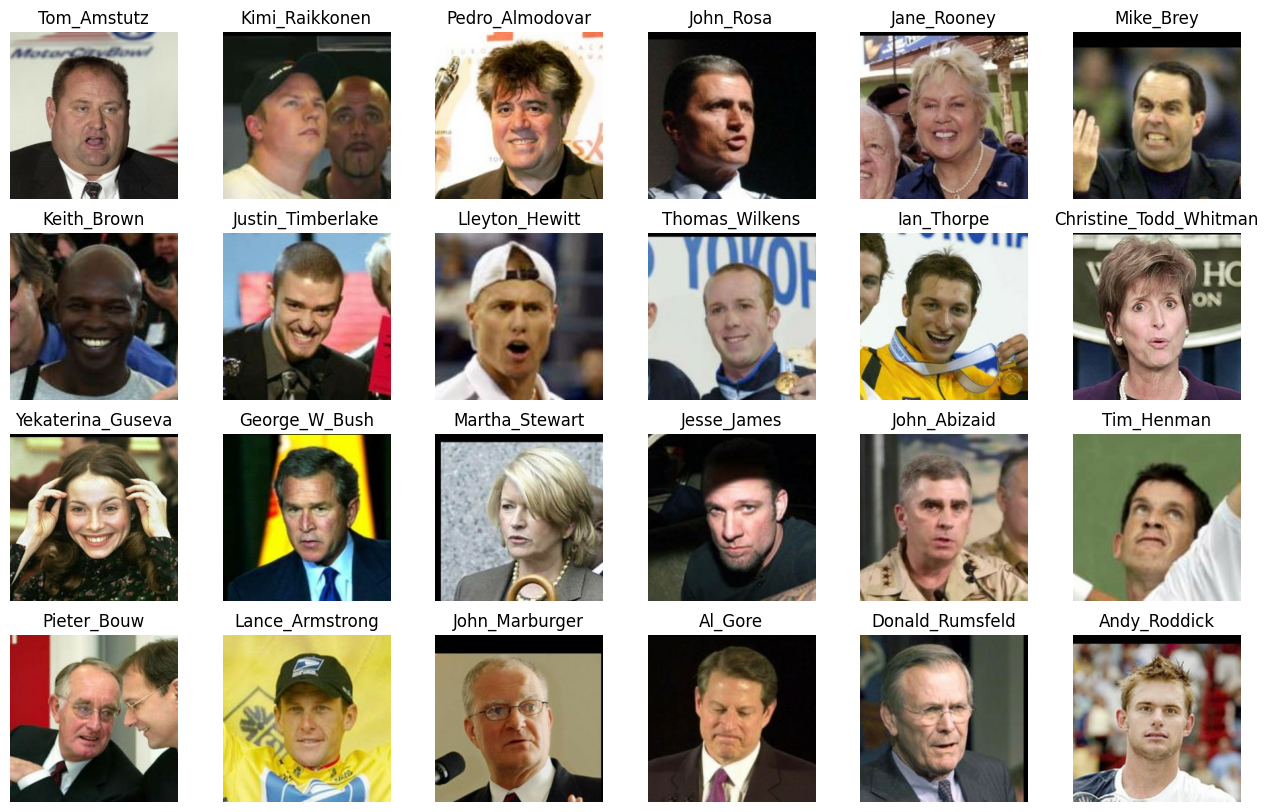

In [4]:
plt.figure(figsize=(16, 10))
for i, data in enumerate(train_ds.take(24)):
    plt.subplot(4, 6, i + 1)
    plt.title(data[0].numpy().decode('utf-8'))
    plt.imshow(data[1])
    plt.axis('off')

In [5]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [6]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, ...]
    embs2 = embs[bs//2:, ...]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)

    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [7]:
BATCH_SIZE = 64
NUM_EPOCHS = 20

def normalize_img(label, image):
    return label, tf.cast(image, tf.float32) / 255.

train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(1)

In [8]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [9]:
%%time

for iter, (labels, images) in enumerate(train_ds):

    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)

    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iter % 100 == 0:
        print(f'[{iter}]\t loss: {loss_value.numpy():.4f}\t')

[0]	 loss: 92.2176	
[100]	 loss: 18.2973	
[200]	 loss: 0.6458	
[300]	 loss: 1.0364	
[400]	 loss: 0.0000	
[500]	 loss: 0.2955	
[600]	 loss: 0.0000	
[700]	 loss: 0.0025	
[800]	 loss: 0.1308	
[900]	 loss: 0.4104	
[1000]	 loss: 0.0970	
[1100]	 loss: 0.1127	
[1200]	 loss: 0.0000	
[1300]	 loss: 0.0000	
[1400]	 loss: 17.7975	
[1500]	 loss: 0.0000	
[1600]	 loss: 0.0000	
[1700]	 loss: 80.1732	
[1800]	 loss: 0.0201	
[1900]	 loss: 0.1180	
[2000]	 loss: 0.1977	
[2100]	 loss: 0.0000	
[2200]	 loss: 5.0266	
[2300]	 loss: 0.0044	
[2400]	 loss: 0.1432	
[2500]	 loss: 0.2325	
[2600]	 loss: 0.0099	
[2700]	 loss: 0.0026	
[2800]	 loss: 0.0000	
[2900]	 loss: 0.0000	
[3000]	 loss: 0.0628	
[3100]	 loss: 0.1965	
[3200]	 loss: 0.1507	
[3300]	 loss: 0.1636	
[3400]	 loss: 0.0000	
[3500]	 loss: 0.8203	
CPU times: user 5min 13s, sys: 2min 20s, total: 7min 33s
Wall time: 12min 40s


In [10]:
test_y = np.array([])
test_embs = tf.concat([model(images) for _, images in test_ds], 0)

for labels, images in test_ds:
    test_y = np.append(test_y, labels.numpy()[0])

In [11]:
def draw_embeddings(X_embedded, targets):
    plt.figure(figsize=(10, 10))
    for class_idx in np.unique(targets)[:24]:
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1], label=class_idx)
        plt.legend()
    plt.grid(True)

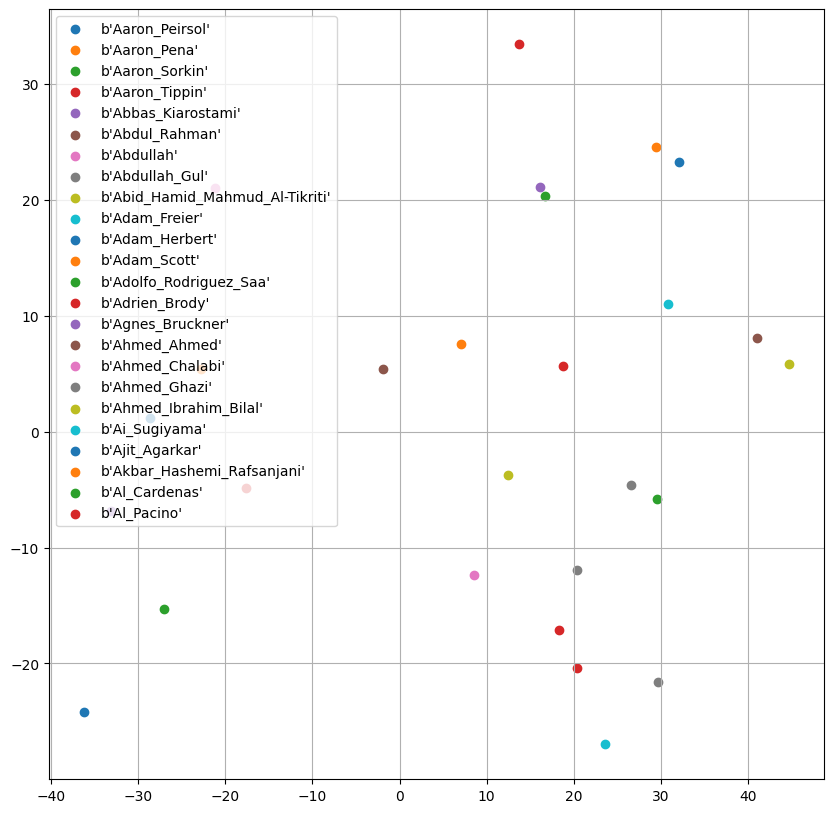

In [12]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
labels_for_viz = test_y

draw_embeddings(test_embs_2D, labels_for_viz)

In [13]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250), order=3, mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

data_path = '/content/'

img_a1 = load_and_prepare_image(data_path + 'Britney_Spears_1.jpg')
img_a2 = load_and_prepare_image(data_path + 'Britney_Spears_2.jpg')
img_a3 = load_and_prepare_image(data_path + 'Reese_Witherspoon.jpg')

<ipython-input-13-9ee2955217f0>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fpath, pilmode="RGB")


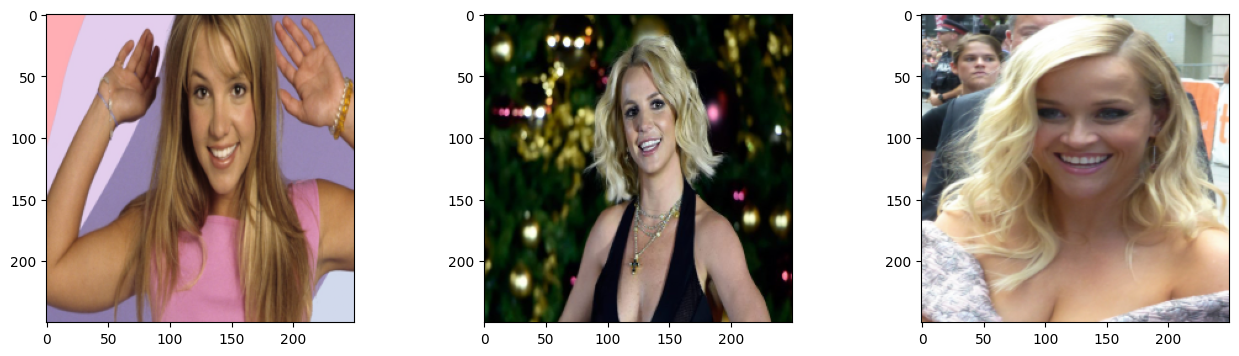

In [14]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_a3)
plt.show()

In [15]:
test_embs = model(np.stack((img_a1, img_a2, img_a3), axis=0))

In [16]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = test_embs[0,:]
emb2 = test_embs[1,:]
emb3 = test_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A1 <-> A3: ', diff(emb1, emb3))
print('A2 <-> A3: ', diff(emb2, emb3))

A1 <-> A2:  14.637123755905842
A1 <-> A3:  14.151348014756955
A2 <-> A3:  15.120848535211397


Вывода два:
- сеть недообучена
- блондинок сеть распознает плохо, все на одно лицо :)
